# Extract deep coadds in ra-dec coordinates

 work with Weakly_2022_44
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/23
- update : 2023/12/23


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
# Astropy
from astropy.visualization import ZScaleInterval, AsinhStretch

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
from astropy.wcs import WCS


plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [9]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [10]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [11]:
all_tracts = np.array([5616, 5634, 5615, 10644, 383, 8188, 3863, 455, 452, 5839, 10643, 382])

In [12]:
#index = 0 # medium, patchy, no entire patch, but low density
#index = 1 # dense field
#index = 2 # medium density galaxy in it
#index = 3 # solar system avoid
#index = 4 # too big on latitude
#index = 5 # too low latitude
index = 6 # low density tract 3863 good patch 242,243
#index = 7 # too dense
#index= 8 # good patch 43
#index = 9 # not interesting
#index = 10 # not interesting
#index = 11 # too dense
itract_sel = all_tracts[index]

## deepCoadd

In [13]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', collections=my_collection, where= "instrument='LATISS'")

In [14]:
all_dataId = []
all_deepcoadds  = []
all_titles = []

all_deepCoadd_wcs = []
all_deepCoadd_bbox = []
all_deepCoadd_corners_ra= []
all_deepCoadd_corners_dec = []
all_xvals = []
all_yvals = []
all_str_tract_patch = []

for i, ref in enumerate(datasetRefs):

    band = ref.dataId["band"]
    tract = ref.dataId["tract"]
    patch = ref.dataId["patch"]

    if tract == itract_sel:
        print(f"========({i})================datasetType = deepCoadd ============================================")
        print("fullId..................:",ref.dataId.full)
        print("band....................:",ref.dataId["band"])
        print("skymap..................:",ref.dataId["skymap"])
        print("tract..................:",ref.dataId["tract"])
        print("patch..................:",ref.dataId["patch"])
        print("run.....................:",ref.run)
    
    
        the_dataId = {'band': band, 'tract': tract, 'patch': patch}
        the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 
        my_deepCoadd = butler.get('deepCoadd', dataId=ref.dataId.full,collections=my_collection)

        #my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=ref.dataId.full)
        #my_deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=ref.dataId.full)
        my_deepCoadd_wcs = my_deepCoadd.wcs
        my_deepCoadd_bbox = my_deepCoadd.getBBox() 
        my_deepCoadd_corners_ra, my_deepCoadd_corners_dec = get_corners_radec(my_deepCoadd_wcs, my_deepCoadd_bbox)
        my_xvals = [my_deepCoadd_corners_ra[0], my_deepCoadd_corners_ra[1], my_deepCoadd_corners_ra[2], \
             my_deepCoadd_corners_ra[3], my_deepCoadd_corners_ra[0]]
        my_yvals = [my_deepCoadd_corners_dec[0], my_deepCoadd_corners_dec[1], my_deepCoadd_corners_dec[2], \
             my_deepCoadd_corners_dec[3], my_deepCoadd_corners_dec[0]]

        str_tract_patch = '(' + str(ref.dataId['tract']) + ', ' + str(ref.dataId['patch'])+')'
        
        all_dataId.append(the_dataId) 
        all_deepcoadds.append(my_deepCoadd)
        all_titles.append(the_title)
        all_deepCoadd_wcs.append( my_deepCoadd_wcs)
        all_deepCoadd_bbox.append(my_deepCoadd_bbox)
        all_deepCoadd_corners_ra.append(my_deepCoadd_corners_ra)
        all_deepCoadd_corners_dec.append(my_deepCoadd_corners_dec)
        all_xvals.append(my_xvals)
        all_yvals.append(my_yvals)
        all_str_tract_patch.append(str_tract_patch)  
    

========(1)================datasetType = deepCoadd ============================================
fullId..................: {band: 'r', skymap: 'latiss_v1', tract: 3863, patch: 243}
band....................: r
skymap..................: latiss_v1
tract..................: 3863
patch..................: 243
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553/20231120T163323Z
========(8)================datasetType = deepCoadd ============================================
fullId..................: {band: 'g', skymap: 'latiss_v1', tract: 3863, patch: 224}
band....................: g
skymap..................: latiss_v1
tract..................: 3863
patch..................: 224
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553/20231120T163323Z
========(14)================datasetType = deepCoadd ============================================
fullId..................: {band: 'r',

## Plot patchs

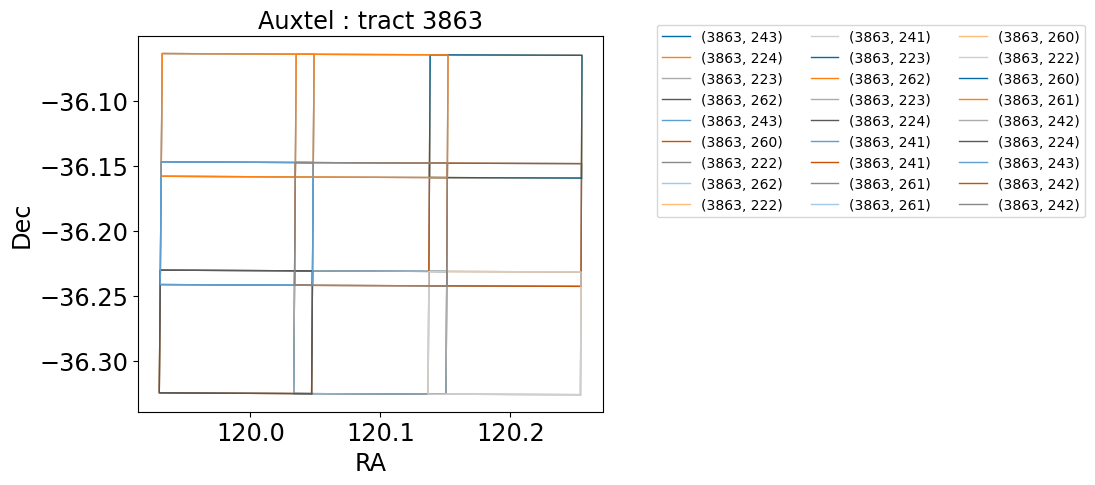

In [15]:
fig = plt.figure(figsize=(6, 6))

for idx,dataid in enumerate(all_dataId):  

    xvals = all_xvals[idx]
    yvals = all_yvals[idx]
    str_tract_patch = all_str_tract_patch[idx]
    plt.plot(xvals, yvals, ls='solid', lw=1, label=str_tract_patch)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=3)
the_title_tract = f"Auxtel : tract {itract_sel}"
plt.title(the_title_tract)
plt.gca().set_aspect('equal')
plt.show()

## plot deepCoadd

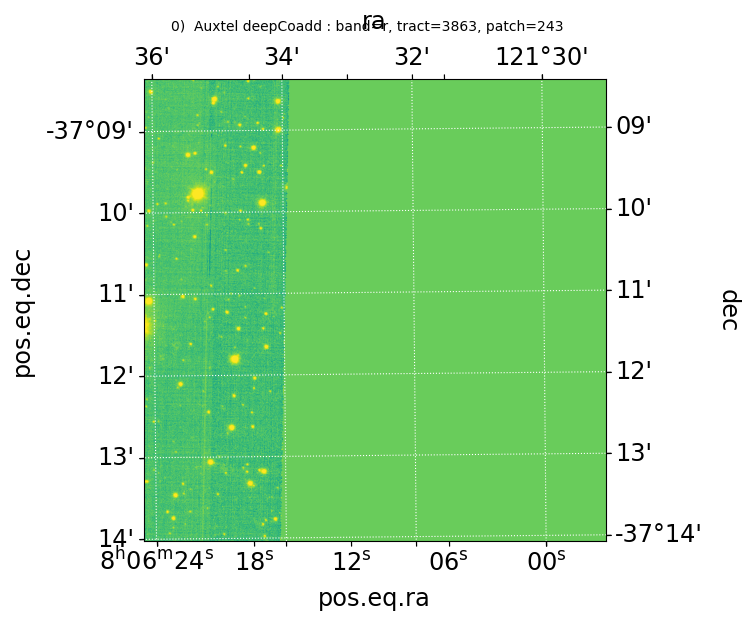

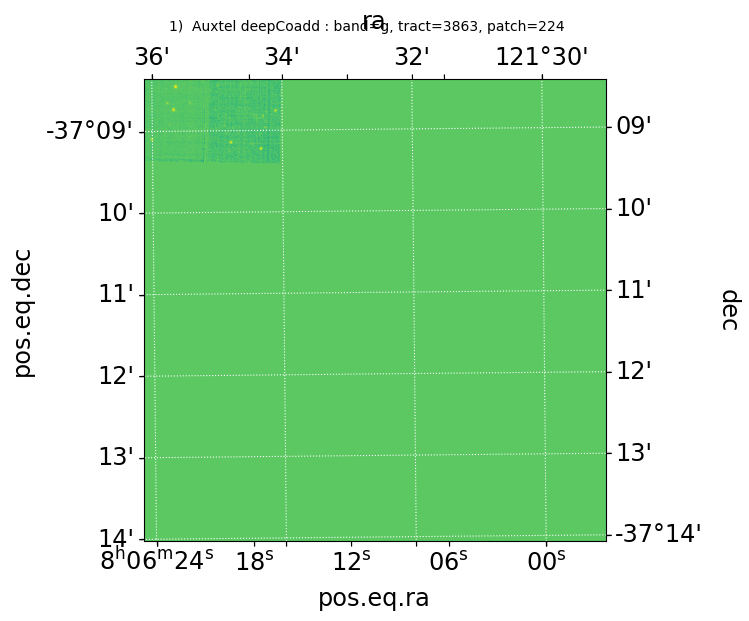

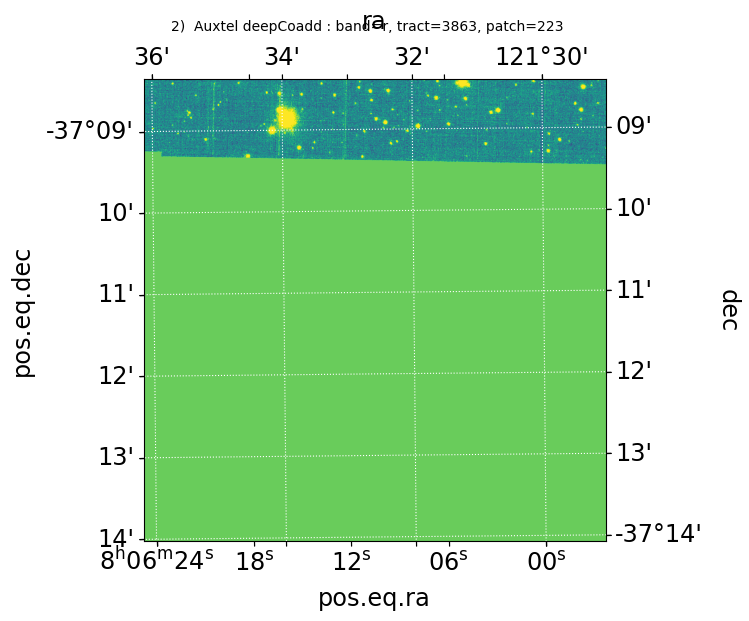

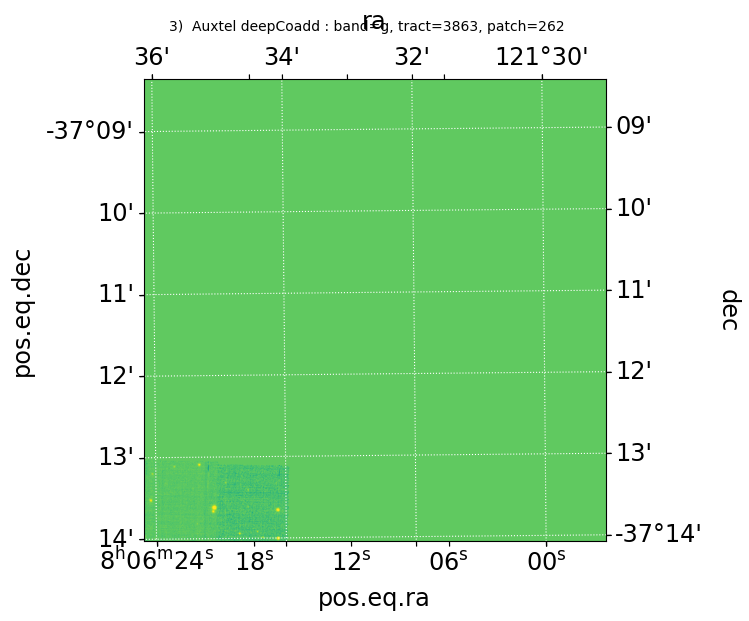

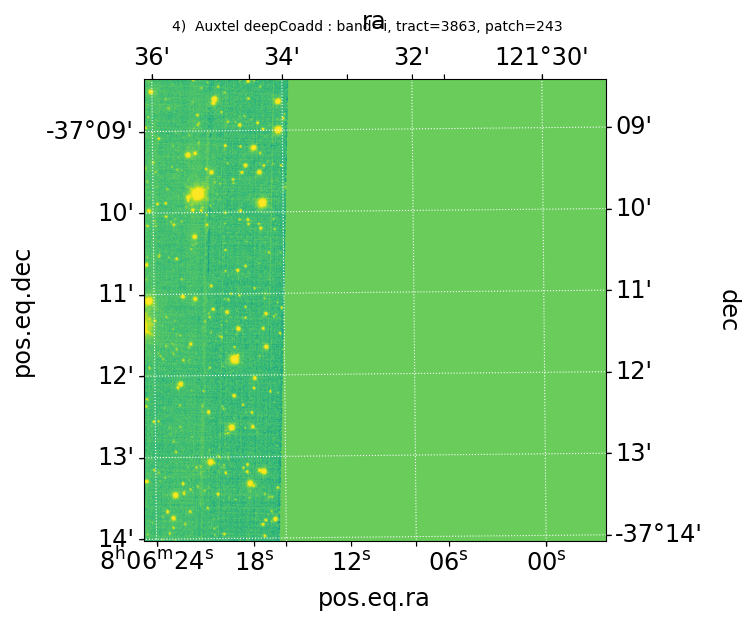

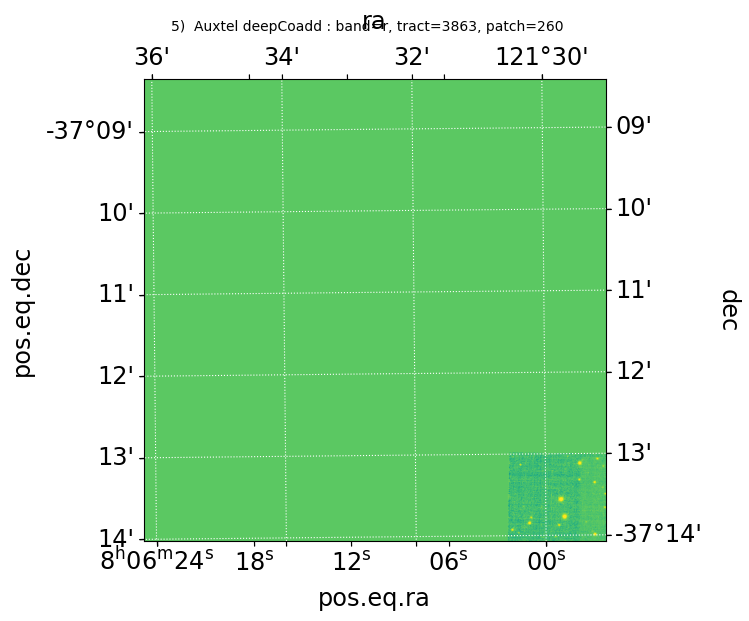

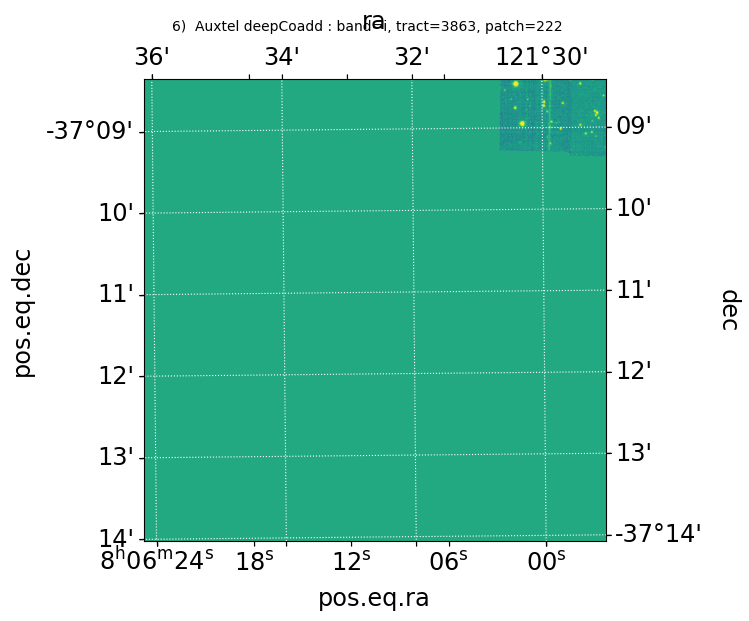

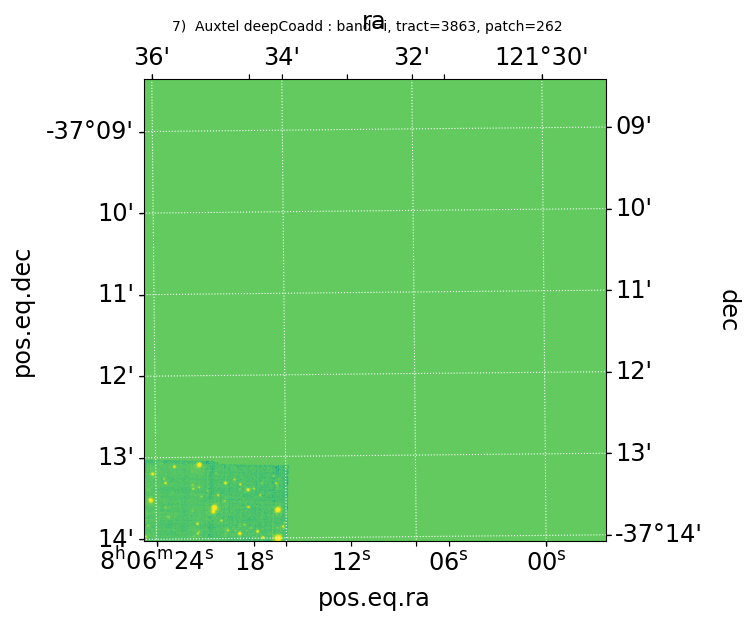

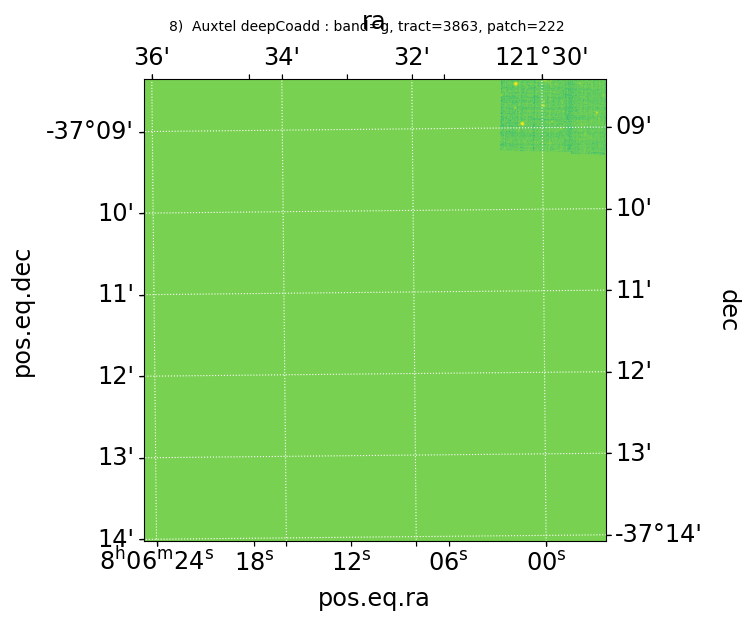

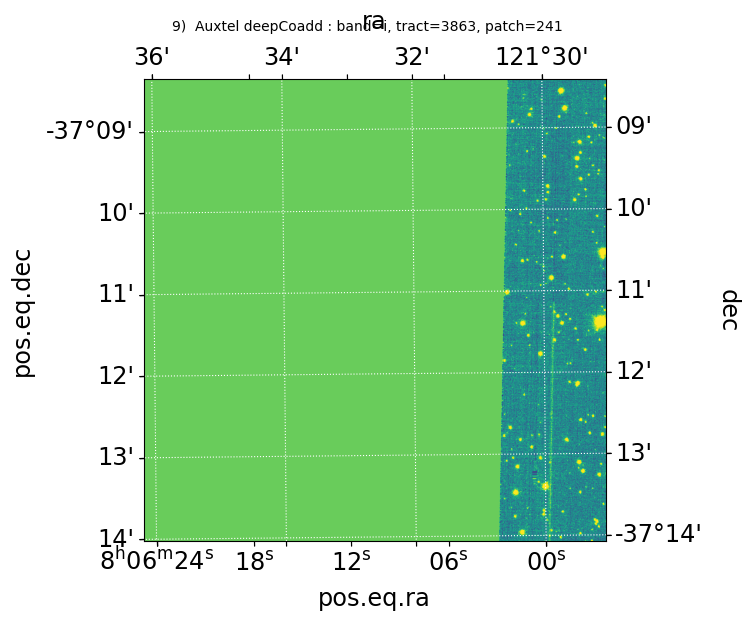

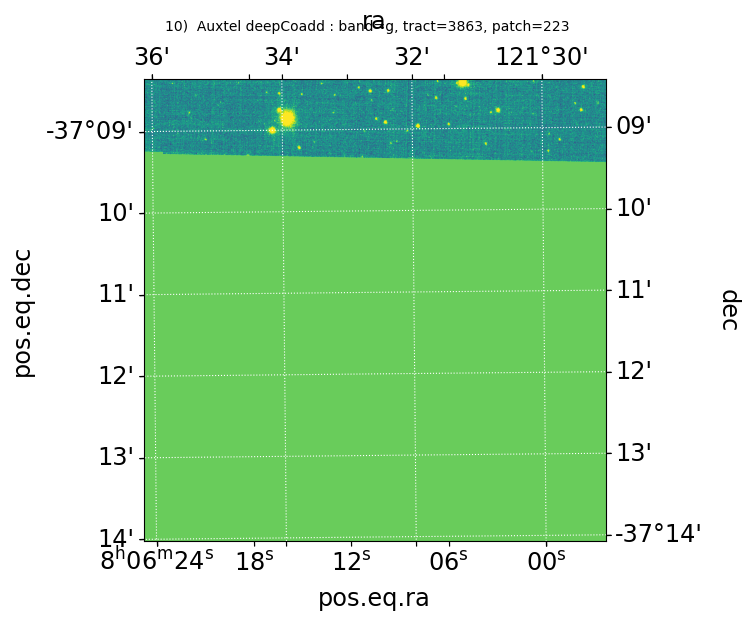

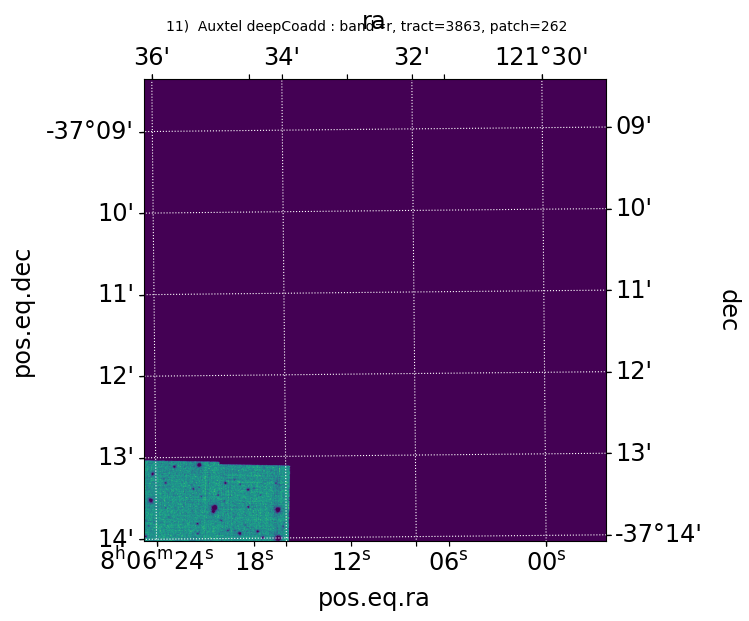

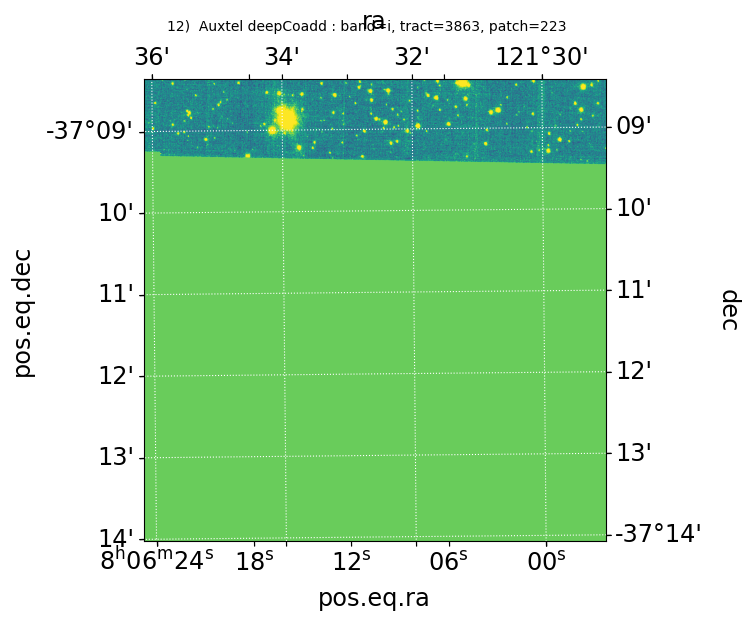

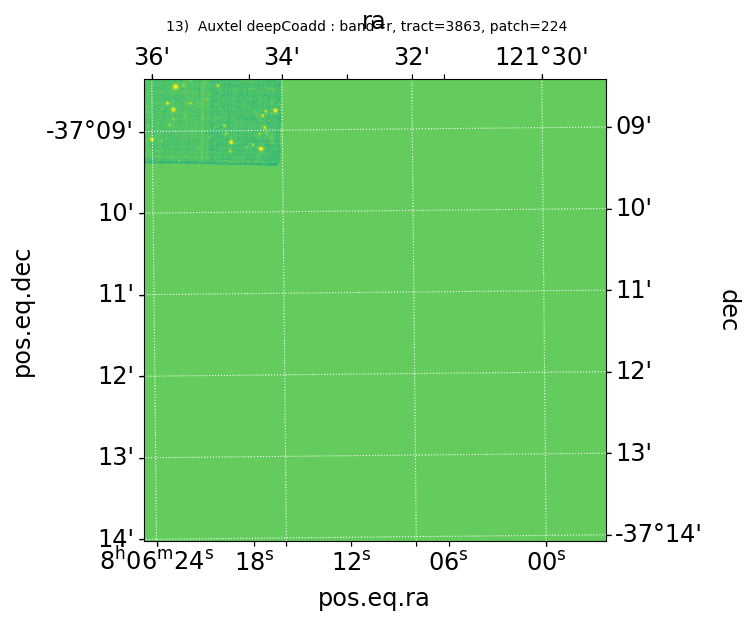

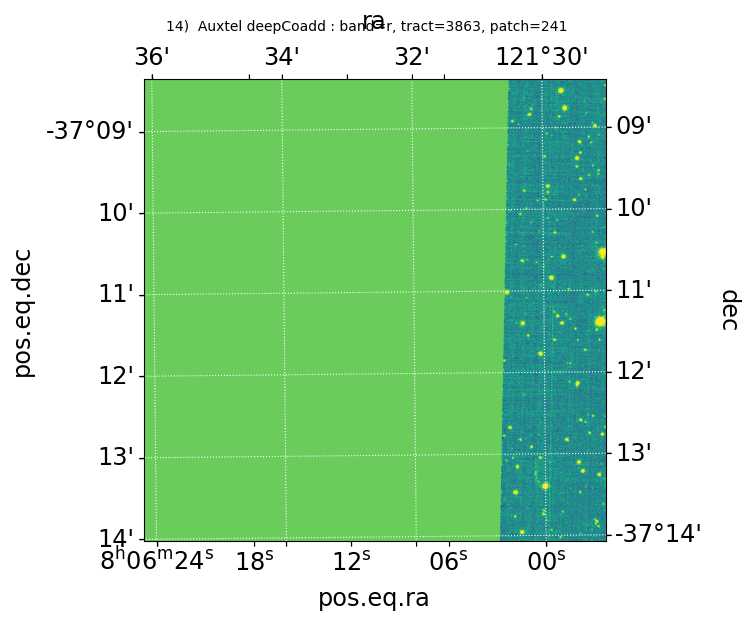

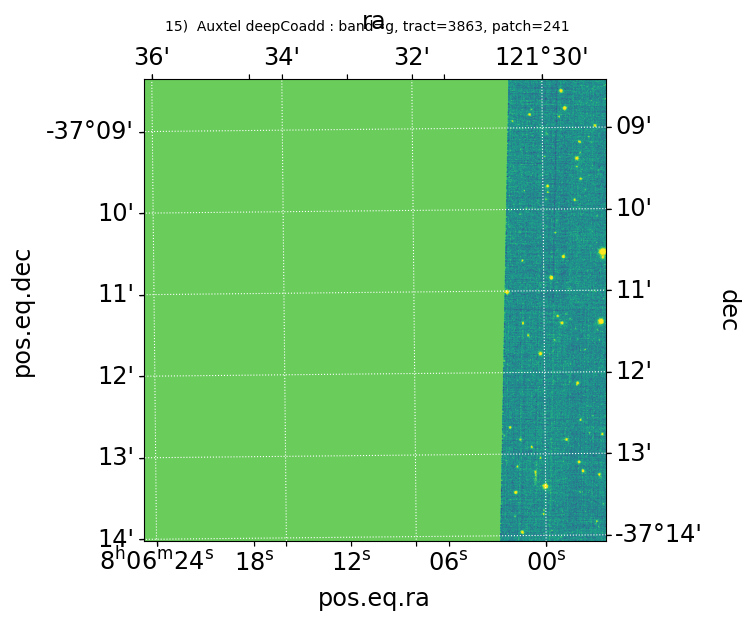

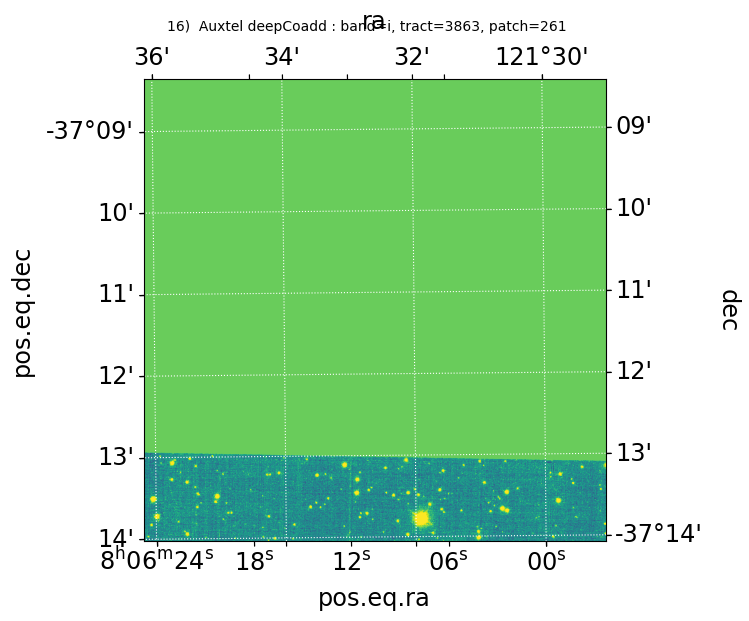

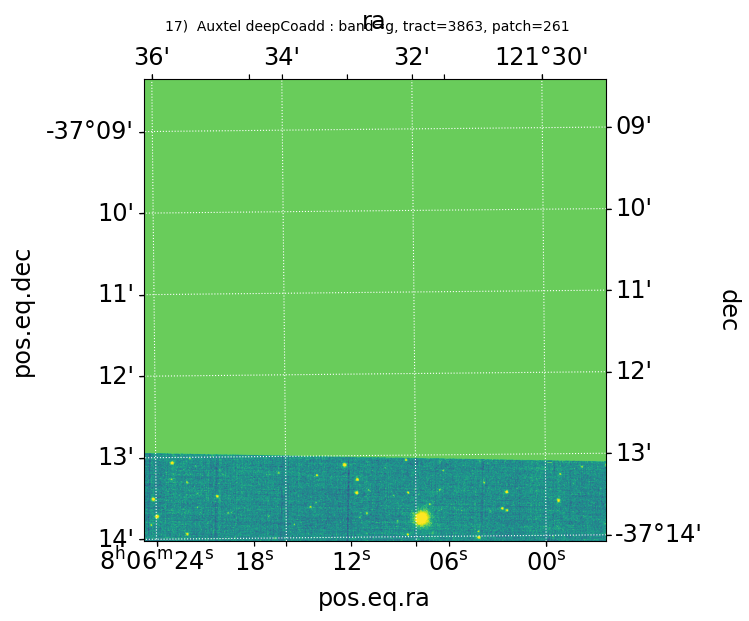

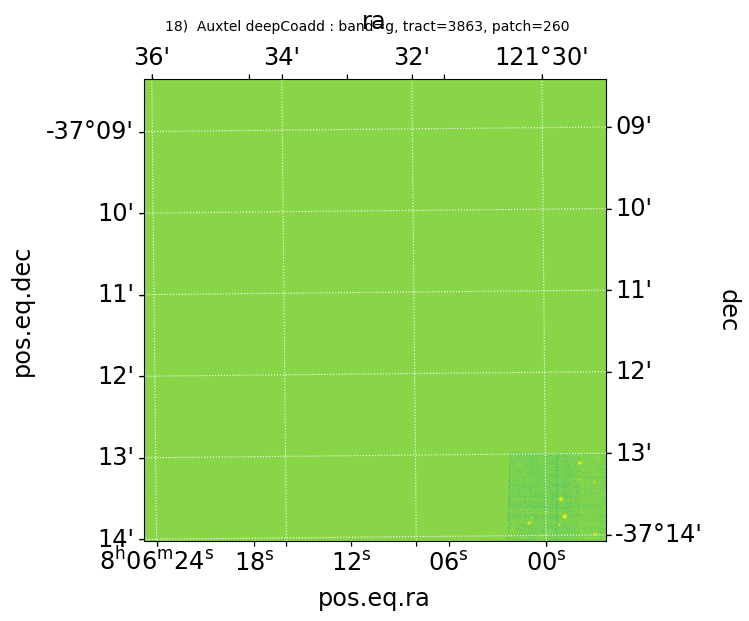

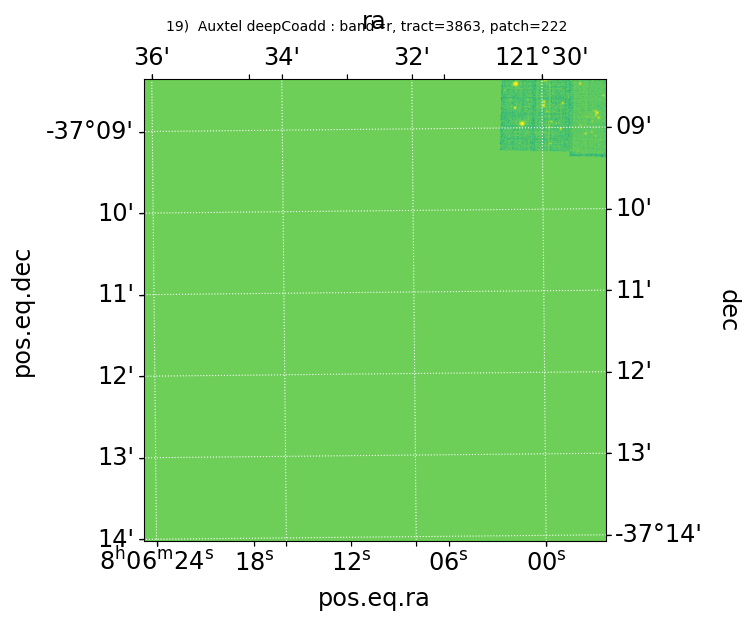

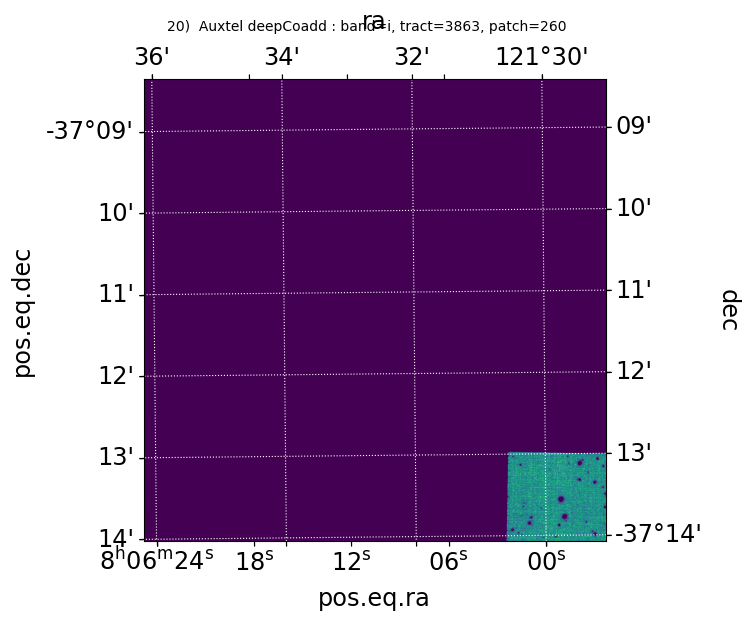

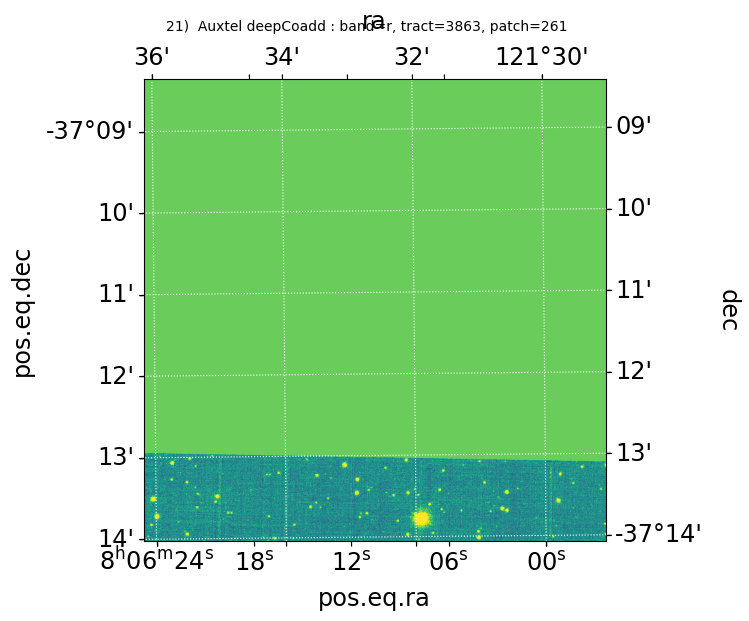

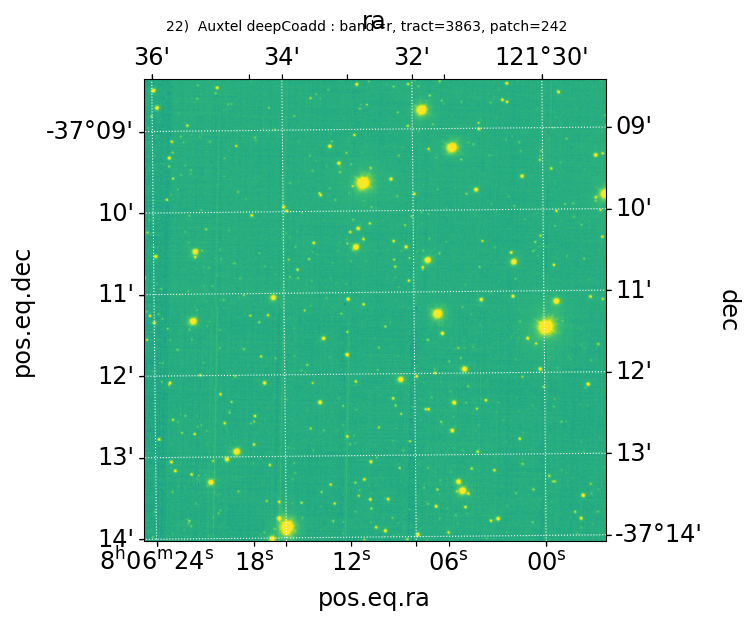

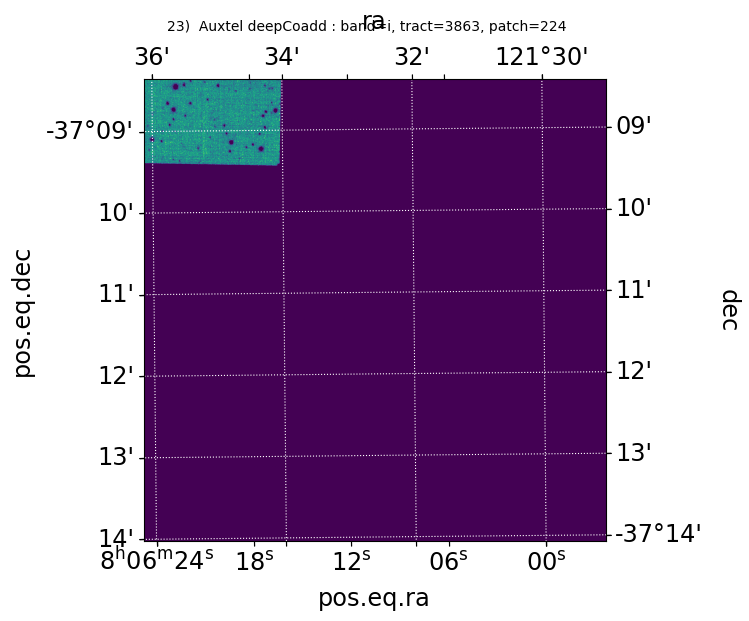

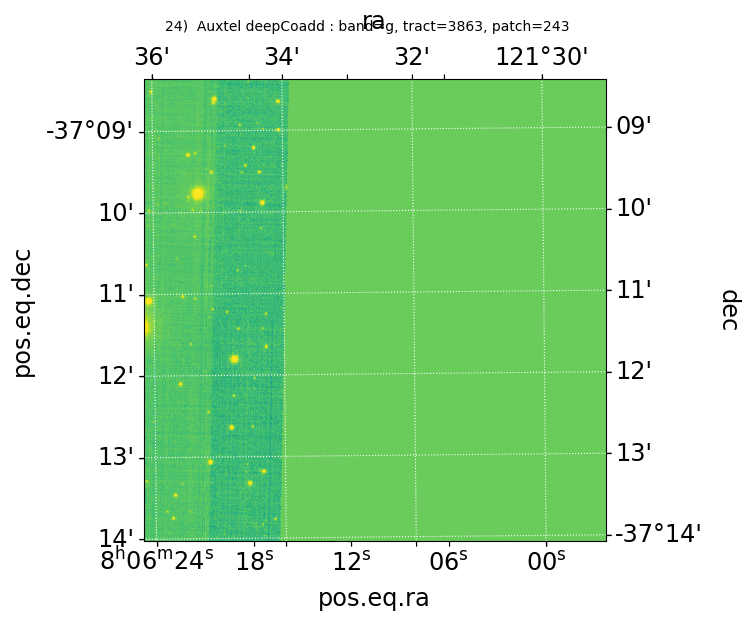

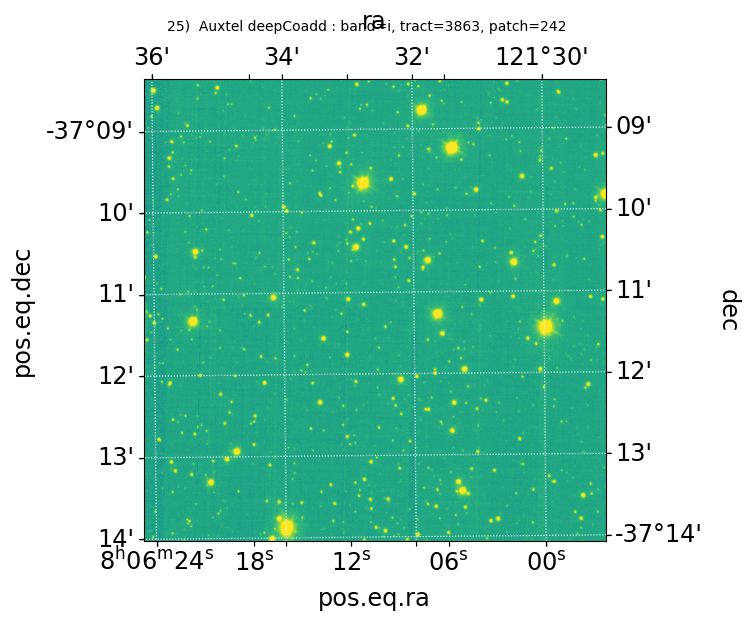

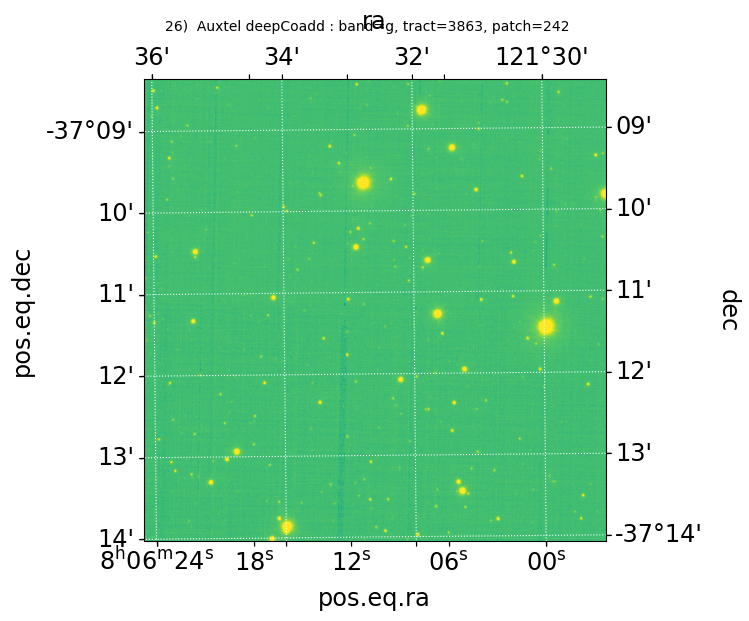

In [17]:
N = len(all_deepcoadds)

for index in range(N):
    the_dataid = all_dataId[index]
    the_deepcoadd = all_deepcoadds[index]
    the_title = f"{index})  "+all_titles[index]
    wcs = all_deepCoadd_wcs[index]

    fitsMd = wcs.getFitsMetadata()
    WCSfMd = WCS(fitsMd)
  
    
    # Plot the calexp we just retrieved
    plt.figure()
    plt.subplot(projection= WCSfMd)
    
    transform = AsinhStretch() + ZScaleInterval()
    scaledImage = transform(the_deepcoadd.image.array)
    #scaledImage = np.flipud(scaledImage)
    plt.imshow(scaledImage,origin="lower")
    plt.suptitle(the_title,fontsize=10)

    ax = plt.gca()
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')
    #plt.tight_layout()
    plt.show()
